In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
import numpy as np
import pandas as pd
from kcsd import KCSD1D

In [4]:
from sglxarray import load_trigger
from ecephys.plot import lfp_explorer, colormesh_timeseries_explorer
from ecephys.signal.utils import mean_subtract, median_subtract
from ecephys.xrsig import get_kcsd
import ecephys_analyses as ea

In [5]:
def mm_to_mask(lo, hi, ele_pos):
    assert lo < hi, "Lower bound must be less than upper bound."     
    return np.logical_and(ele_pos >= lo, ele_pos <= hi).flatten()

def mm_to_idx(lo, hi, ele_pos):
    idx = np.where(millimeters_to_mask(lo, hi, ele_pos))[0]
    return idx

def mm_to_chans(lo, hi, ele_pos, chans):
    return chans[mm_to_mask(lo, hi, ele_pos)]

In [6]:
SUBJECT = "Segundo"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1680 # pick a 1 second window that has SPW-Rs

In [31]:
SUBJECT = "Segundo"
EXPERIMENT = "isoflurane"
CONDITION = "all"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

In [9]:
SUBJECT = "Valentino"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 3880 # pick a 1 second window that has SPW-Rs

In [10]:
SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 355 # pick a 1 second window that has SPW-Rs

In [19]:
# During Dex-induced theta, in 2-25-2020_g0_t1

SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2986 # pick a 1 second window that has SPW-Rs

In [10]:
SUBJECT = "Valentino"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 828 # pick a 1 second window that has SPW-Rs

In [15]:
SUBJECT = "Valentino"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 83 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.1
wm_center = 6.12
wm_thickness = 0.133

In [66]:
SUBJECT = "Valentino"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.866
hpc_hi = 6.166
wm_center = 6.36
wm_thickness = 0.133

In [97]:
SUBJECT = "Valentino"
EXPERIMENT = "ketamine-90mg"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 16 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.856
hpc_hi = 6.156
wm_center = 6.28
wm_thickness = 0.133

In [165]:
SUBJECT = "Doppio"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1708 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

In [48]:
SUBJECT = "Doppio"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.133

In [77]:
SUBJECT = "Doppio"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 202 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.0
wm_center = 5.94
wm_thickness = 0.133

In [8]:
SUBJECT = "Doppio"
EXPERIMENT = "atropine-50mg"
CONDITION = "all"
START_TIME = 1159 # pick a 1 second window that has SPW-Rs

In [39]:
SUBJECT = "Doppio"
EXPERIMENT = "ketamine-120mg"
CONDITION = "all"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

In [189]:
SUBJECT = "Alessandro"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1766 # pick a 1 second window that has SPW-Rs

In [158]:
SUBJECT = "Alessandro"
EXPERIMENT = "dexmedetomidine-eStim"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2008 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.0
hpc_hi = 6.05
wm_center = 6.15
wm_thickness = 0.1

In [215]:
SUBJECT = "Eugene"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 2600 # pick a 1 second window that has SPW-Rs

In [239]:
SUBJECT = "Allan"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 2007 # pick a 1 second window that has SPW-Rs

In [7]:
SUBJECT = "Allan"
EXPERIMENT = "dexmedetomidine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 3 # pick a 1 second window that has SPW-Rs

In [8]:
SUBJECT = "Allan"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 35 # pick a 1 second window that has SPW-Rs

In [106]:
SUBJECT = "Allan"
EXPERIMENT = "ketamine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 1791 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.2
hpc_hi = 5.4
wm_center = 5.48
wm_thickness = 0.133

In [62]:
SUBJECT = "Luigi"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
PROBE = "imec0"
START_TIME = 410 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.5
hpc_hi = 5.6
wm_center = 5.7
wm_thickness = 0.133

In [95]:
SUBJECT = "Luigi"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec0"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.55
hpc_hi = 5.25
wm_center = 5.35
wm_thickness = 0.1

In [60]:
SUBJECT = "Charles"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
PROBE = "imec1"
START_TIME = 1185 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.95
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.1

In [41]:
SUBJECT = "Charles"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.7
hpc_hi = 5.6
wm_center = 5.72
wm_thickness = 0.1

In [52]:
SUBJECT = "Adrian"
EXPERIMENT = "conveyor_over_water"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 550 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.22
hpc_hi = 6.26
wm_center = 6.4
wm_thickness = 0.133

In [18]:
SUBJECT = "Adrian"
EXPERIMENT = "sleep_homeostasis"
ALIAS = "recovery_sleep"
PROBE = "imec1"
START_TIME = 4 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.22
hpc_hi = 6.26
wm_center = 6.4
wm_thickness = 0.133

## 1D kCSD on whole probe

In [19]:
chans = ea.get_channels(SUBJECT, EXPERIMENT, PROBE, "all")

In [20]:
bin_path = ea.get_raw_files(SUBJECT, EXPERIMENT, ALIAS, probe=PROBE, stream="lf", ftype="bin").path.values[0]
#bin_path = ea.get_sglx_style_datapaths(subject=SUBJECT, experiment=EXPERIMENT, condition=CONDITION, ext="lf.bin")[0]

In [21]:
sig = load_trigger(bin_path, chans, start_time=(START_TIME), end_time=(START_TIME + 1.0))
sig.values = mean_subtract(sig.values)

nChan: 385, nFileSamp: 18000083


In [22]:
electrode_pitch = 0.020
ele_pos = np.arange(0, len(sig.channel)) * electrode_pitch
csd = get_kcsd(
    sig, ele_pos, gdx=electrode_pitch, do_lcurve=True
)

Performing L-curve parameter estimation...
No lambda given, using defaults
min lambda 1e-09
max lambda 0.0043
min lambda 1e-09
max lambda 0.0043
l-curve (all lambda):  0.23
Best lambda and R =  0.000807613616857016 ,  0.23


In [23]:
print(f"Hippocampus: {hpc_lo}mm, {hpc_hi}mm")
hpc_chans = csd.sel(pos=slice(hpc_lo, hpc_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {hpc_chans}")
print("")

wm_lo = wm_center - wm_thickness
wm_hi = wm_center + wm_thickness
print(f"White matter: {wm_lo}mm, {wm_hi}mm")
wm_chans = csd.sel(pos=slice(wm_lo, wm_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {wm_chans}")

Hippocampus: 4.22mm, 6.26mm
Channels:
 [ 39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73
  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107 109
 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143 145
 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179 181
 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215 217
 219 221 223 225 227 229 231 233 235 237 239 241 243]

White matter: 6.267mm, 6.533mm
Channels:
 [245 247 249 251 253 255 257 259 261 263 265 267 269]


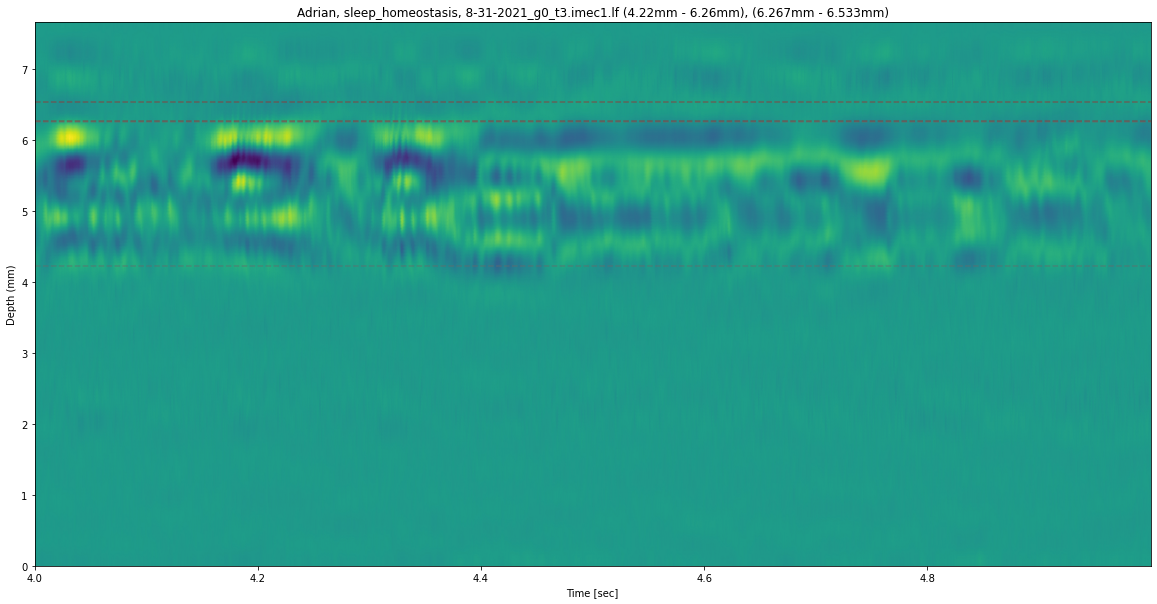

In [24]:
_, ax = plt.subplots(figsize=(20, 10))
ax.pcolormesh(csd.time.values, csd.kcsd.estm_x, csd.values, shading="gouraud")
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Depth (mm)")
ax.set_title(f"{SUBJECT}, {EXPERIMENT}, {bin_path.stem} ({hpc_lo}mm - {hpc_hi}mm), ({wm_lo}mm - {wm_hi}mm)")
ax.axhline(hpc_hi, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(hpc_lo, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(wm_hi, alpha=0.5, color='brown', linestyle="--")
ax.axhline(wm_lo, alpha=0.5, color='brown', linestyle="--")

In [25]:
hpc_chans

array([ 39,  41,  43,  45,  47,  49,  51,  53,  55,  57,  59,  61,  63,
        65,  67,  69,  71,  73,  75,  77,  79,  81,  83,  85,  87,  89,
        91,  93,  95,  97,  99, 101, 103, 105, 107, 109, 111, 113, 115,
       117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141,
       143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167,
       169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193,
       195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219,
       221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243])

In [26]:
print(f"Drift tracking: {hpc_lo - 0.1}mm, {hpc_hi + 0.1}mm")
tracking_chans = csd.sel(pos=slice(hpc_lo - 0.1, hpc_hi + 0.1)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:")
tracking_chans

Drift tracking: 4.12mm, 6.359999999999999mm
Channels:


array([ 29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,  53,
        55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,
        81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131,
       133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157,
       159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183,
       185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209,
       211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235,
       237, 239, 241, 243, 245, 247, 249, 251])